# Optimizing Model - Creating Average Flight Delays

In [1]:
import pandas as pd
import numpy as np
import psycopg2
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import datetime
from scipy import stats
from sklearn.model_selection import train_test_split

In [2]:
data_flight_info = pd.read_csv('/Users/craiglynch/Desktop/Lighthouse_Labs/Mid-term_Project/mid-term-project-I-master/data_for_model_iterations_03.csv', sep = ',')

In [3]:
df_flight_info = data_flight_info.copy()

In [4]:
df_flight_info.tail()

,fl_date,mkt_unique_carrier,op_unique_carrier,op_carrier_fl_num,origin,dep_time,crs_dep_time,dep_delay,dest,arr_time,...,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay,year,month,day,weekday,total_carrier_delay
978881,2019-08-08,HA,HA,18,HNL,1456.0,1500,-4.0,LAS,2331.0,...,0.0,0.0,0.0,0.0,0.0,2019,8,8,0.0,8.817211
978882,2018-03-12,HA,HA,22,HNL,1326.0,1325,1.0,SEA,2157.0,...,0.0,0.0,0.0,0.0,0.0,2018,3,12,0.0,8.817211
978883,2019-07-14,HA,HA,12,HNL,1327.0,1315,12.0,SFO,2141.0,...,0.0,0.0,0.0,0.0,0.0,2019,7,14,1.0,8.817211
978884,2018-10-26,HA,HA,18,HNL,1503.0,1510,-7.0,LAS,2329.0,...,0.0,0.0,0.0,0.0,0.0,2018,10,26,0.0,8.817211
978885,2019-08-06,HA,HA,34,OGG,1401.0,1345,16.0,LAX,2214.0,...,0.0,0.0,0.0,0.0,0.0,2019,8,6,0.0,8.817211


In [5]:
## Grouping Delays

# Finding average route times
df_flight_info['flight_number'] = df_flight_info['op_unique_carrier'] + df_flight_info['op_carrier_fl_num'].astype(str)
route_time_grouped = df_flight_info.groupby(by='flight_number').mean()
route_time_grouped.reset_index(inplace=True)
route_time_grouped['average_route_time'] = route_time_grouped['actual_elapsed_time']
route_time_grouped = route_time_grouped[['flight_number','average_route_time']]

In [6]:
# Getting Average NAS Delay - Grouped by Flight Number
nas_grouped = df_flight_info.groupby(by='flight_number').mean()
nas_grouped.reset_index(inplace=True)
nas_grouped['total_nas_delay'] = nas_grouped['nas_delay']
nas_grouped = nas_grouped[['flight_number', 'total_nas_delay']]


# Getting Average Security Delay
security_grouped = df_flight_info.groupby(by='origin').mean()
security_grouped.reset_index(inplace=True)
security_grouped['total_security_delay'] = security_grouped['security_delay']
security_grouped = security_grouped[['origin','total_security_delay']]

# Getting Average Departure Delays by Route
dep_delay_grouped = df_flight_info.groupby(by='flight_number').mean()
dep_delay_grouped.reset_index(inplace=True)
dep_delay_grouped['total_dep_delay'] = dep_delay_grouped['dep_delay']
dep_delay_grouped = dep_delay_grouped[['flight_number','total_dep_delay']]

# Getting Average Arrival Delays by Route
arr_delay_grouped = df_flight_info.groupby(by='flight_number').mean()
arr_delay_grouped.reset_index(inplace=True)
arr_delay_grouped['total_arr_delay'] = arr_delay_grouped['arr_delay']
arr_delay_grouped = arr_delay_grouped[['flight_number','total_arr_delay']]

#Merge averages dataframes with original 
df_flight_info = df_flight_info.merge(security_grouped, on = 'origin', how = 'outer')
df_flight_info = df_flight_info.merge(nas_grouped, on = 'flight_number', how = 'outer')
df_flight_info = df_flight_info.merge(route_time_grouped, on = 'flight_number', how = 'outer')
df_flight_info = df_flight_info.merge(dep_delay_grouped, on = 'flight_number', how = 'outer')
df_flight_info = df_flight_info.merge(arr_delay_grouped, on = 'flight_number', how = 'outer')

## Model Training

In [7]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, recall_score, precision_score, r2_score, f1_score
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyRegressor
from sklearn.cluster import KMeans
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.linear_model import Ridge, LinearRegression, Lasso
from sklearn.preprocessing import PolynomialFeatures
from sklearn.utils import shuffle

In [8]:
df_flight_info["flight_number"] = df_flight_info["flight_number"].astype('category').cat.codes

In [9]:
df_flight_info.head(1)

,fl_date,mkt_unique_carrier,op_unique_carrier,op_carrier_fl_num,origin,dep_time,crs_dep_time,dep_delay,dest,arr_time,...,month,day,weekday,total_carrier_delay,flight_number,total_security_delay,total_nas_delay,average_route_time,total_dep_delay,total_arr_delay
0,2018-10-19,NK,NK,169,IAH,1433.0,1435,-2.0,LAS,1552.0,...,10,19,0.0,5.841662,14561,0.00354,0.723404,204.553191,6.319149,-0.170213


In [10]:
df_flight_info = shuffle(df_flight_info)
X = df_flight_info[['crs_dep_time','flight_number','crs_elapsed_time','average_route_time','crs_arr_time','distance','total_carrier_delay', 'total_security_delay','total_nas_delay','total_dep_delay','total_arr_delay']]
y = df_flight_info['arr_delay']

In [11]:
# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3) # 70% training and 30% test

##### LightGBM

In [12]:
import lightgbm as lgb
d_train = lgb.Dataset(X_train, label=y_train)
params = {}
params['learning_rate'] = 0.08
params['boosting_type'] = 'gbdt'
#params['boosting_type'] = 'dart'
params['objective'] = 'regression'
params['metric'] = 'mse'
params['sub_feature'] = 0.5
params['num_leaves'] = 100
params['min_data'] = 5
params['max_depth'] = 100
y_train=y_train.ravel()
reg= lgb.train(params, d_train, 100)
results=reg.predict(X_test)
print('Model RMSE is: ',np.sqrt(mean_squared_error(y_test, results)))
print('Model R2 Score is: ',r2_score(y_test,results))

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006689 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2428
[LightGBM] [Info] Number of data points in the train set: 685220, number of used features: 11
[LightGBM] [Info] Start training from score 5.271411
Model RMSE is:  42.70613750591222
Model R2 Score is:  0.050942948614566275


[LightGBM] [Warning] Unknown parameter: 0.01
[LightGBM] [Warning] Unknown parameter: slient
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] Unknown parameter: 0.8
[LightGBM] [Warning] Unknown parameter: 0.01
[LightGBM] [Warning] Unknown parameter: slient
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] Unknown parameter: 0.8
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.057707 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2429
[LightGBM] [Info] Number of data points in the train set: 685220, number of used features: 11
[LightGBM] [Warning] Unknown parameter: 0.01
[LightGBM] [Warning] Unknown parameter: slient
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] Unknown parameter: 0.8
[LightGBM] [Info] Start training from score 5.271411
Training until validation scores don't improve for 100 rounds
[100]	training's l2: 1781.52	valid_1's l

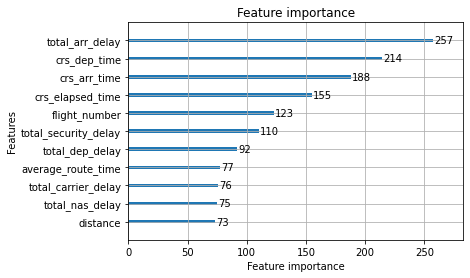

In [13]:
from lightgbm import plot_importance
import matplotlib.pyplot  as plt



params = {
    'booster': 'rf',
    'objective': 'regression',
    'num_leaves': 31,
    'subsample': 0.8,
    'bagging_freq': 1,
    'feature_fraction ': 0.8,
    'slient': 1,
    'learning_rate ': 0.01,
    'seed': 0
}


# Construct training set
dtrain = lgb.Dataset(X_train,y_train)
dtest = lgb.Dataset(X_test,y_test)
num_rounds = 500
# xgboost model training
model = lgb.train(params,dtrain, num_rounds, valid_sets=[dtrain, dtest], 
                  verbose_eval=100, early_stopping_rounds=100)

# Make predictions on the test set
y_pred = model.predict(X_test)
print('Model RMSE is: ',np.sqrt(mean_squared_error(y_test, y_pred)))
print('Model R2 Score is: ',r2_score(y_test,y_pred))

# Show important features
plot_importance(model)
plt.show()

##### XGBoost

In [14]:
data_dmatrix = xgb.DMatrix(data=X,label=y)
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 10)
xg_reg.fit(X_test,y_test)

y_pred_xgb = xg_reg.predict(X_test)

print('Model RMSE is: ',np.sqrt(mean_squared_error(y_test, y_pred_xgb)))
print('Model R2 Score is: ',r2_score(y_test,y_pred_xgb))

Model RMSE is:  42.97196449009156
Model R2 Score is:  0.0390912490582378


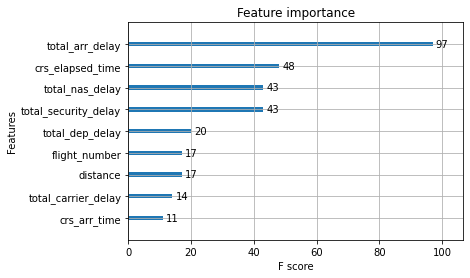

In [15]:
#Examine the importance of each feature column in the original data set with the model
xgb.plot_importance(xg_reg)
plt.rcParams['figure.figsize'] = [50, 50]
plt.show()

##### Ridge Regression

In [16]:
# ss = StandardScaler()
# X_scaled = ss.fit_transform(X)
# # Split dataset into training set and test set
# X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(X_scaled, y, test_size=0.3) # 70% training and 30% test
# ridgereg = Ridge(alpha=0.001,normalize=True)
# poly = PolynomialFeatures(degree = 3)
# X_ = poly.fit_transform(X_test_scaled)
# results = ridgereg.fit(X_train_scaled,y_train_scaled)
# y_pred_scaled = results.predict(X_test_scaled)
# print('Model RMSE is: ',np.sqrt(mean_squared_error(y_test_scaled, y_pred_scaled)))
# print('Model R2 Score is: ',r2_score(y_test_scaled,y_pred_scaled))

##### Random Forest

In [17]:
# #Create a Gaussian Regressor
# clf=RandomForestRegressor(n_estimators=100)
# #Train the model using the training sets 
# clf.fit(X_train,y_train)
# y_pred=clf.predict(X_test)
# print('Model RMSE is: ',np.sqrt(mean_squared_error(y_test, y_pred)))
# print('Model R2 Score is: ',r2_score(y_test,y_pred))